# EDA for W261 Criteo Display Advertising Challenge

First, get things set up.

In [ ]:
%%bash
pip install missingno

In [1]:
from operator import add
from collections import defaultdict
import csv
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.stats import chi2_contingency
import seaborn as sb
import matplotlib.pyplot as plt
import missingno as msno
plt.style.use("ggplot")

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "w261_final_eda"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

## Loading Data
Subset the data and load some of it into memory.

In [4]:
# shuf is a linux commands that gets a random permutation of the lines of a file
!shuf -n 100000 data/train.txt > data/sample.txt

/bin/sh: line 1: 34998 Killed                  shuf -n 100000 data/train.txt > data/sample.txt


In [5]:
rawRDD = spark.read.csv("data/sample.txt", header=False, sep="\t").rdd
dataRDD = rawRDD.map(lambda row: ([None if el is None else int(el) for el in row[1:14]] + list(row[14:]), int(row[0])))

In [6]:
sample = dataRDD.takeSample(withReplacement=False, num=10000)

numeric_columns = np.array([pair[0][:13] for pair in sample], dtype=np.float)
numeric_df = pd.DataFrame(numeric_columns)

category_columns = np.array([pair[0][13:] for pair in sample])
category_df = pd.DataFrame(category_columns)

labels = np.array([pair[1] for pair in sample])

## Analyze 13 Numeric Columns

First, see how many values are missing.

In [6]:
# get percentage of NaN values for each column
for i in numeric_df:
    print(i, ": ", np.mean(np.isnan(numeric_df[i])))

0 :  0.4572
1 :  0.0
2 :  0.2151
3 :  0.2141
4 :  0.0247
5 :  0.2211
6 :  0.0402
7 :  0.0006
8 :  0.0402
9 :  0.4572
10 :  0.0402
11 :  0.7586
12 :  0.2141


Let's also visualize that. This will help to see if the missing values are correlated. Gray means not missing and white means missing.

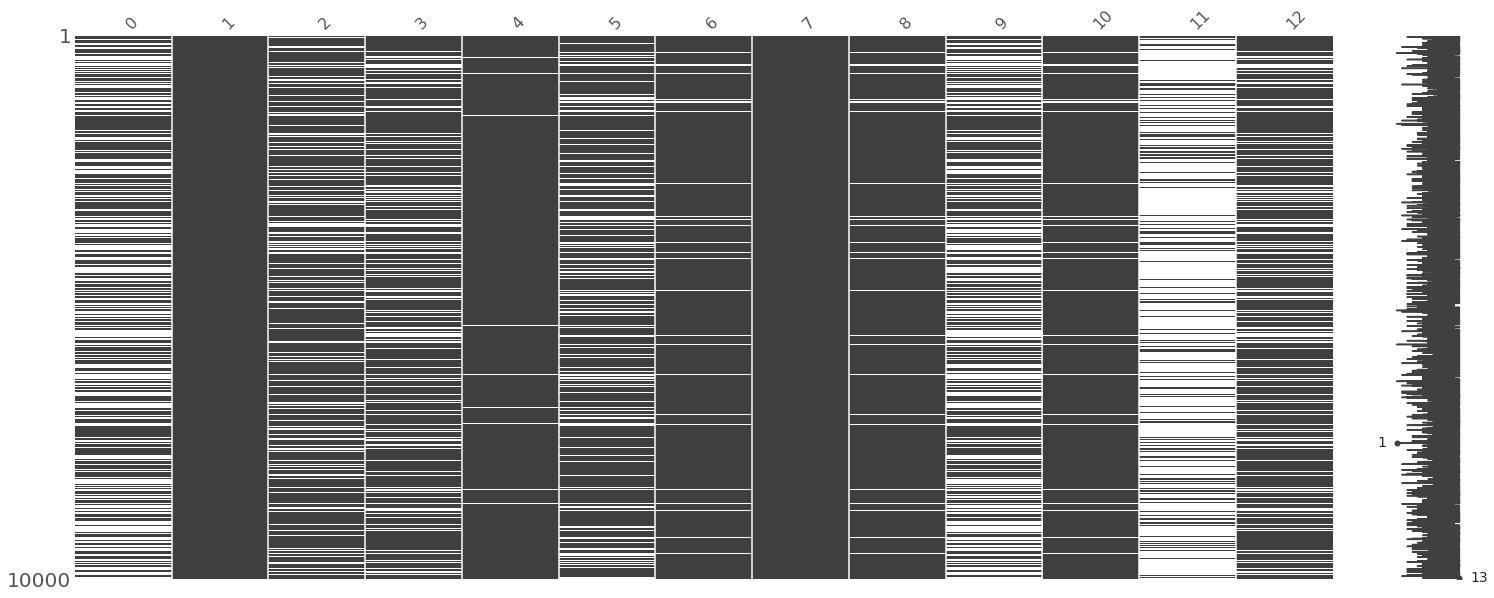

In [7]:
# plot positions of missing values
msno.matrix(numeric_df);

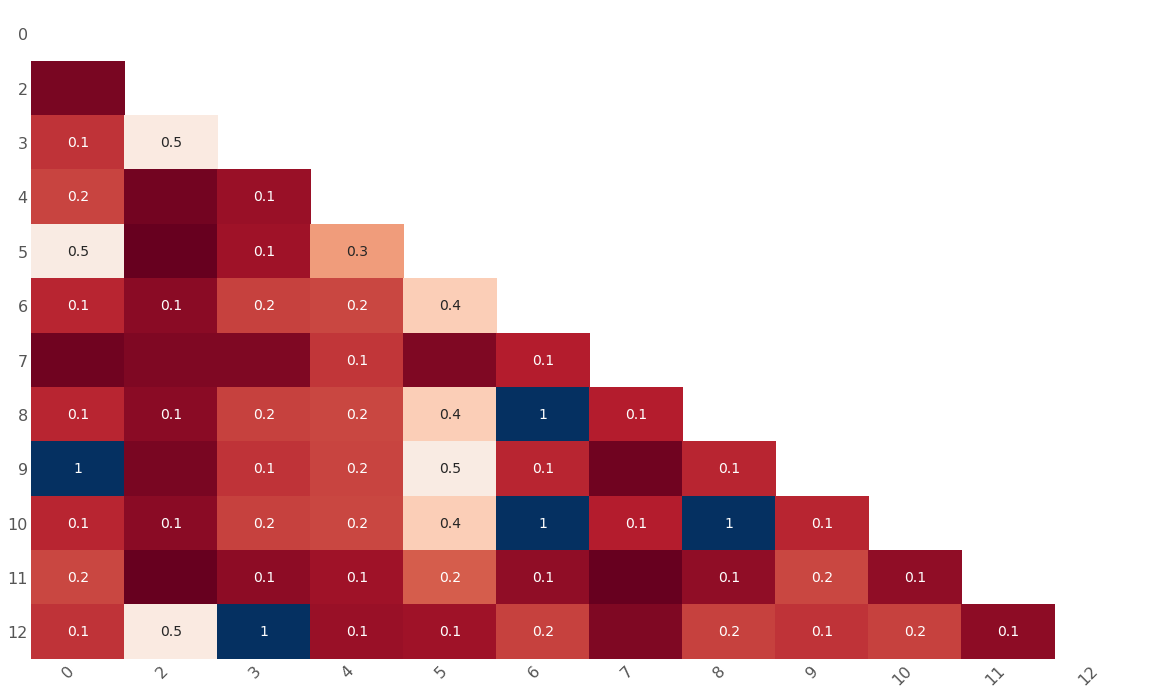

In [8]:
# explicit heatmap showing how correlated the missing values are. for example, this shows that whenever column 9 is `null`, column 0 is always `null` too
msno.heatmap(numeric_df);

Next, look at the spread of the values which are present, such as histograms.

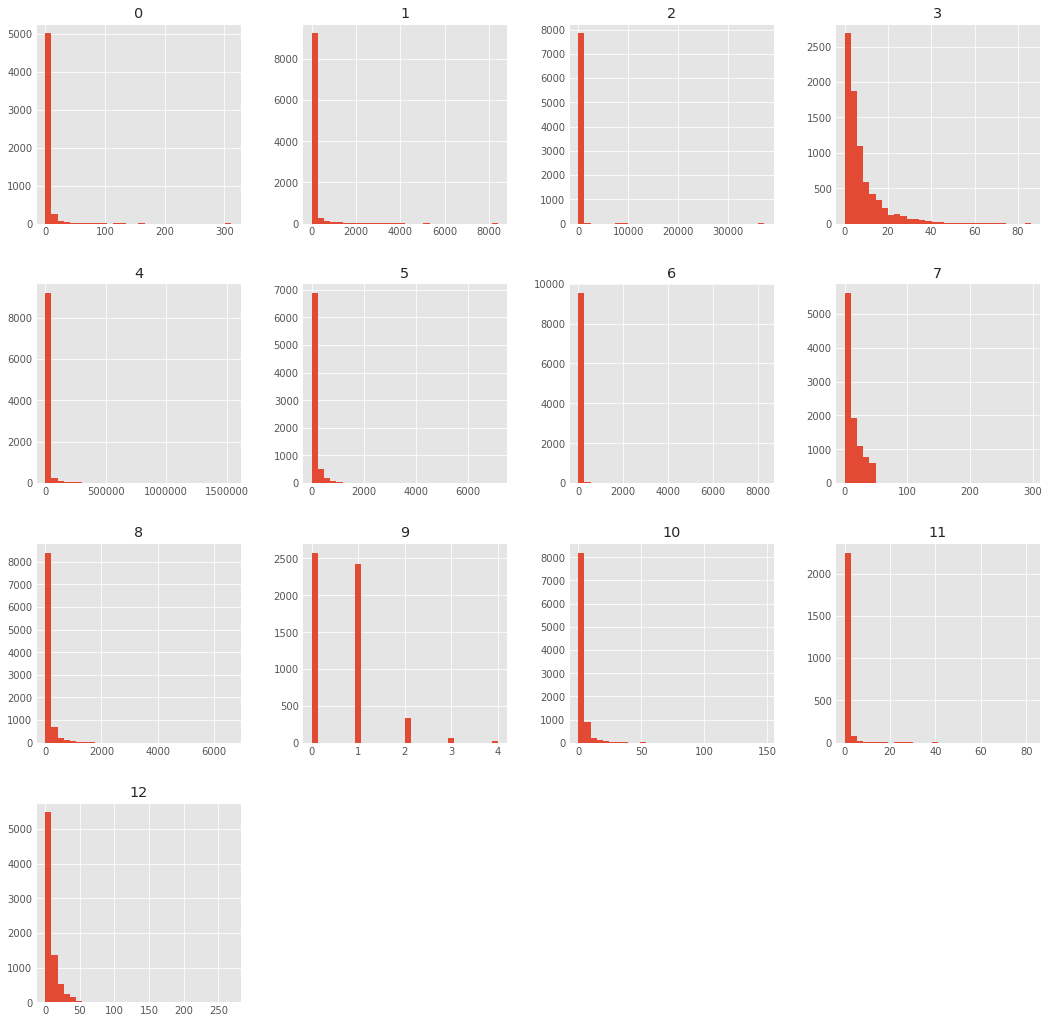

In [9]:
numeric_df.hist(figsize=(18, 18), bins=30);

These are all very skewed. Let's also look at a log-transform (and add constant value to avoid issues with 0's).

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


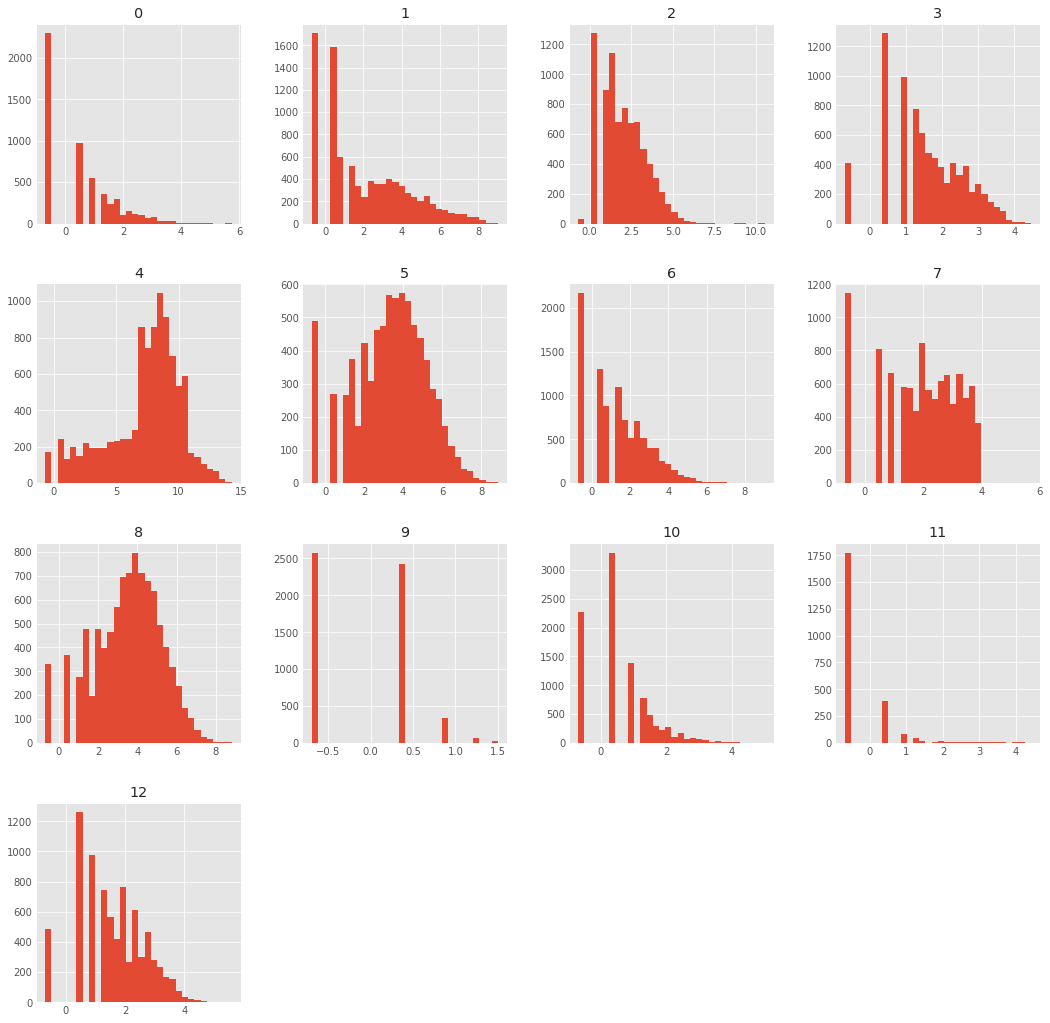

In [10]:
np.log(numeric_df + 0.5).hist(figsize=(18, 18), bins=30);

Let's look at some other aggregate statistics, like quantiles, means, and extremes. Whoa there are some negative values. Weird!

In [13]:
numeric_df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,5470.0,3.440219,9.358740,0.0,0.0,1.0,3.0,253.0
1,10000.0,106.062000,379.233449,-2.0,0.0,3.0,37.0,4802.0
2,7929.0,29.992559,537.416622,0.0,2.0,6.0,17.0,37259.0
3,7889.0,7.440994,8.761958,0.0,2.0,4.0,10.0,151.0
4,9753.0,17060.446119,63315.649415,0.0,313.0,2796.0,10150.0,1310303.0
5,7780.0,116.174679,315.746184,0.0,8.0,33.0,105.0,8731.0
6,9600.0,16.902083,88.873733,0.0,1.0,3.0,12.0,4888.0
7,9998.0,12.658132,13.210878,0.0,2.0,8.0,19.0,174.0
8,9600.0,106.736667,212.057648,0.0,11.0,39.0,115.0,4652.0
9,5470.0,0.622121,0.680142,0.0,0.0,1.0,1.0,4.0


Are the features correlated with one another? Only a few seem to be correlated. This is good, as it means there aren't many redundant features.

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


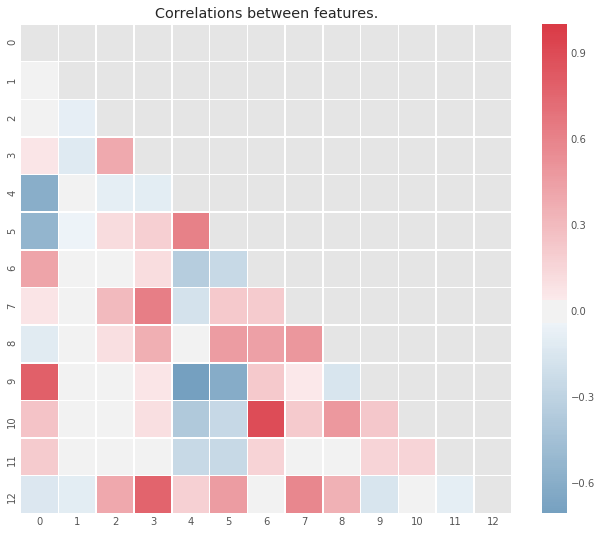

In [12]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = np.log(numeric_df + 0.5).corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sb.diverging_palette(240, 10, as_cmap=True)
sb.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

In [ ]:
# this isn't actually very informative, so nevermind
#scatter_matrix(np.log(numeric_df + 0.5), figsize=(18, 18));

## Analyze 26 Categorical Columns

Again, start by analyzing for missing values.

In [13]:
# get percent of missing values for each column

for i in category_df:
    print(i, ": ", np.mean(category_df[i].isna()))

0 :  0.0
1 :  0.0
2 :  0.0348
3 :  0.0348
4 :  0.0
5 :  0.118
6 :  0.0
7 :  0.0
8 :  0.0
9 :  0.0
10 :  0.0
11 :  0.0348
12 :  0.0
13 :  0.0
14 :  0.0
15 :  0.0348
16 :  0.0
17 :  0.0
18 :  0.4402
19 :  0.4402
20 :  0.0348
21 :  0.765
22 :  0.0
23 :  0.0348
24 :  0.4402
25 :  0.4402


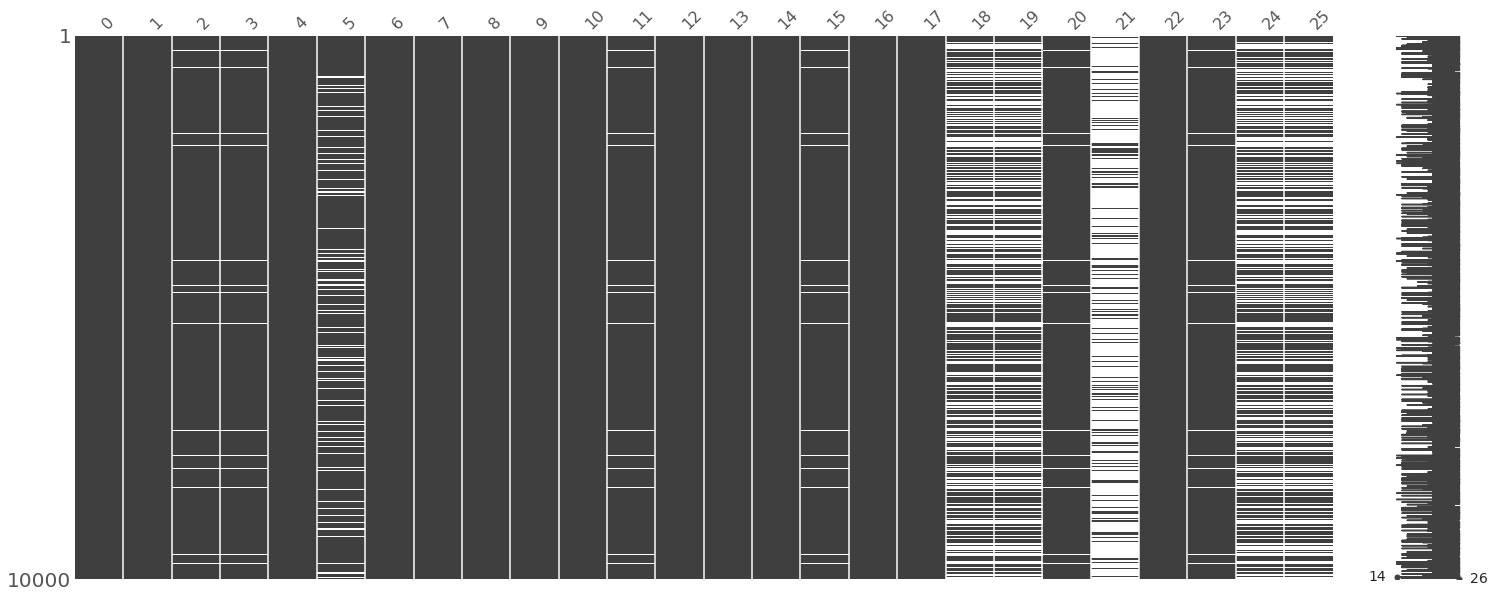

In [14]:
# plot positions of missing values
msno.matrix(category_df);

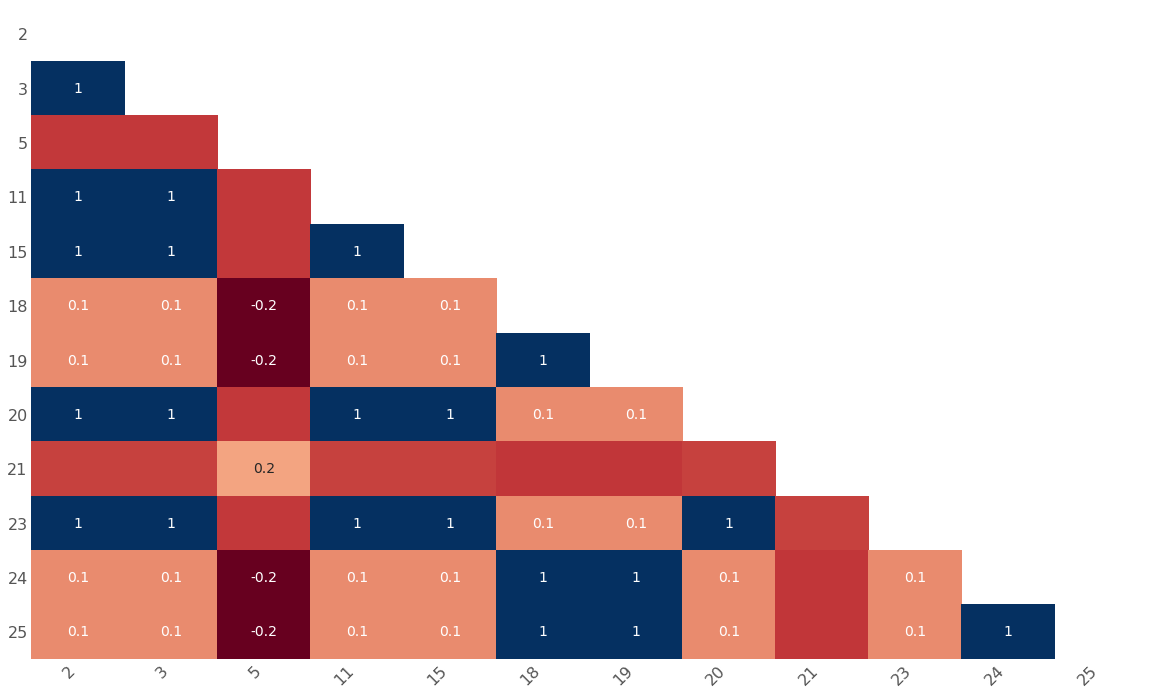

In [15]:
msno.heatmap(category_df)

The missing values are clearly correlated! Most of these look good, but some have mostly missing values. Next, we see that many of these columns don't really have a small group of categories. Instead, there are a large number of rare catergories! What a mess!

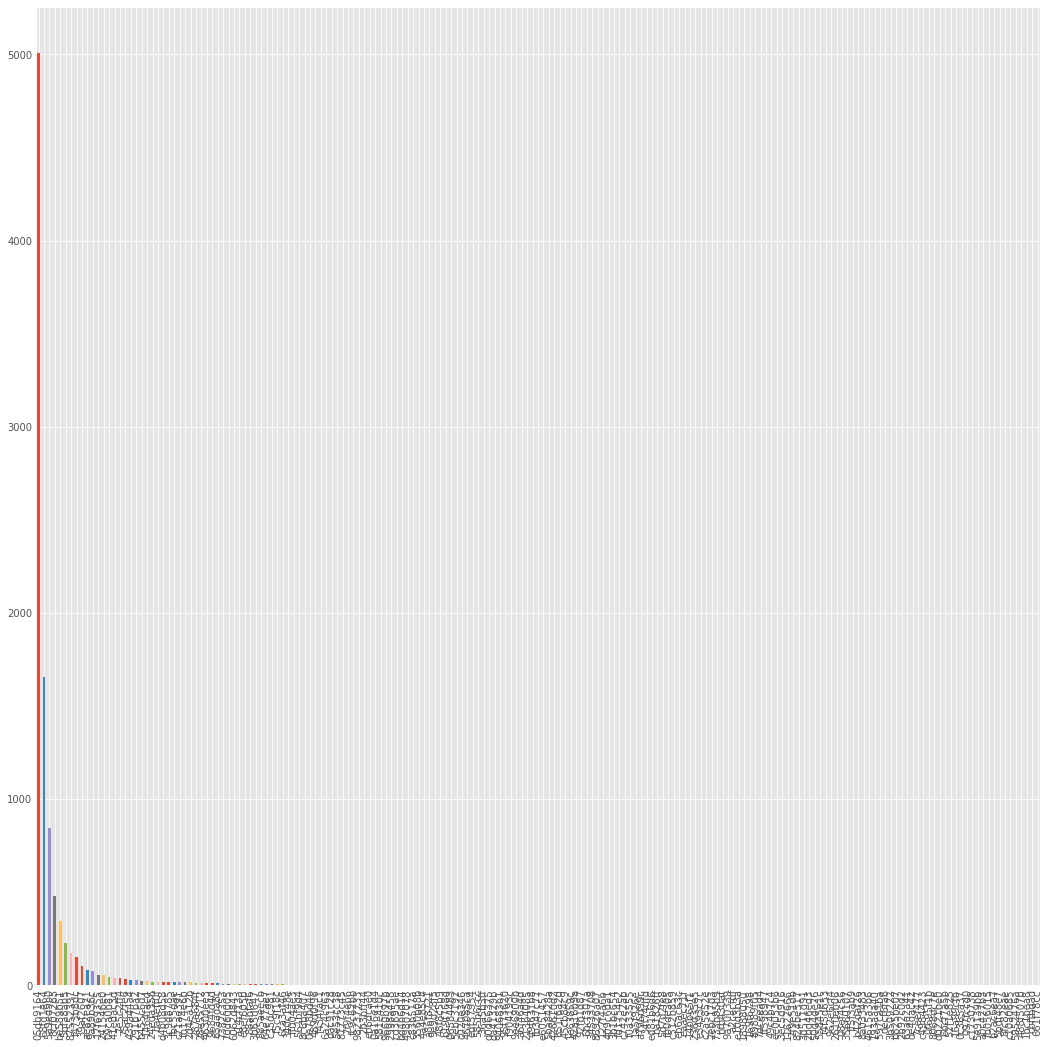

In [16]:
# plot counts for all the possible values of the first column. there are too many categories that appear only once!
counts = pd.value_counts(category_df[0]).plot(kind="bar", figsize=(18, 18))

In [17]:
category_df.describe().T

,count,unique,top,freq
0,10000,185,05db9164,5005
1,10000,401,38a947a1,1105
2,9652,5968,d032c263,262
3,9652,4252,c18be181,367
4,10000,54,25c83c98,6667
5,8820,7,7e0ccccf,4041
6,10000,3306,1c86e0eb,208
7,10000,99,0b153874,5981
8,10000,3,a73ee510,8981
9,10000,3307,3b08e48b,2204


Next, plot histograms for the counts. This shows how widespread this rare-category problem is, as mote columns have a huge number of rare classes (classes with a low count).

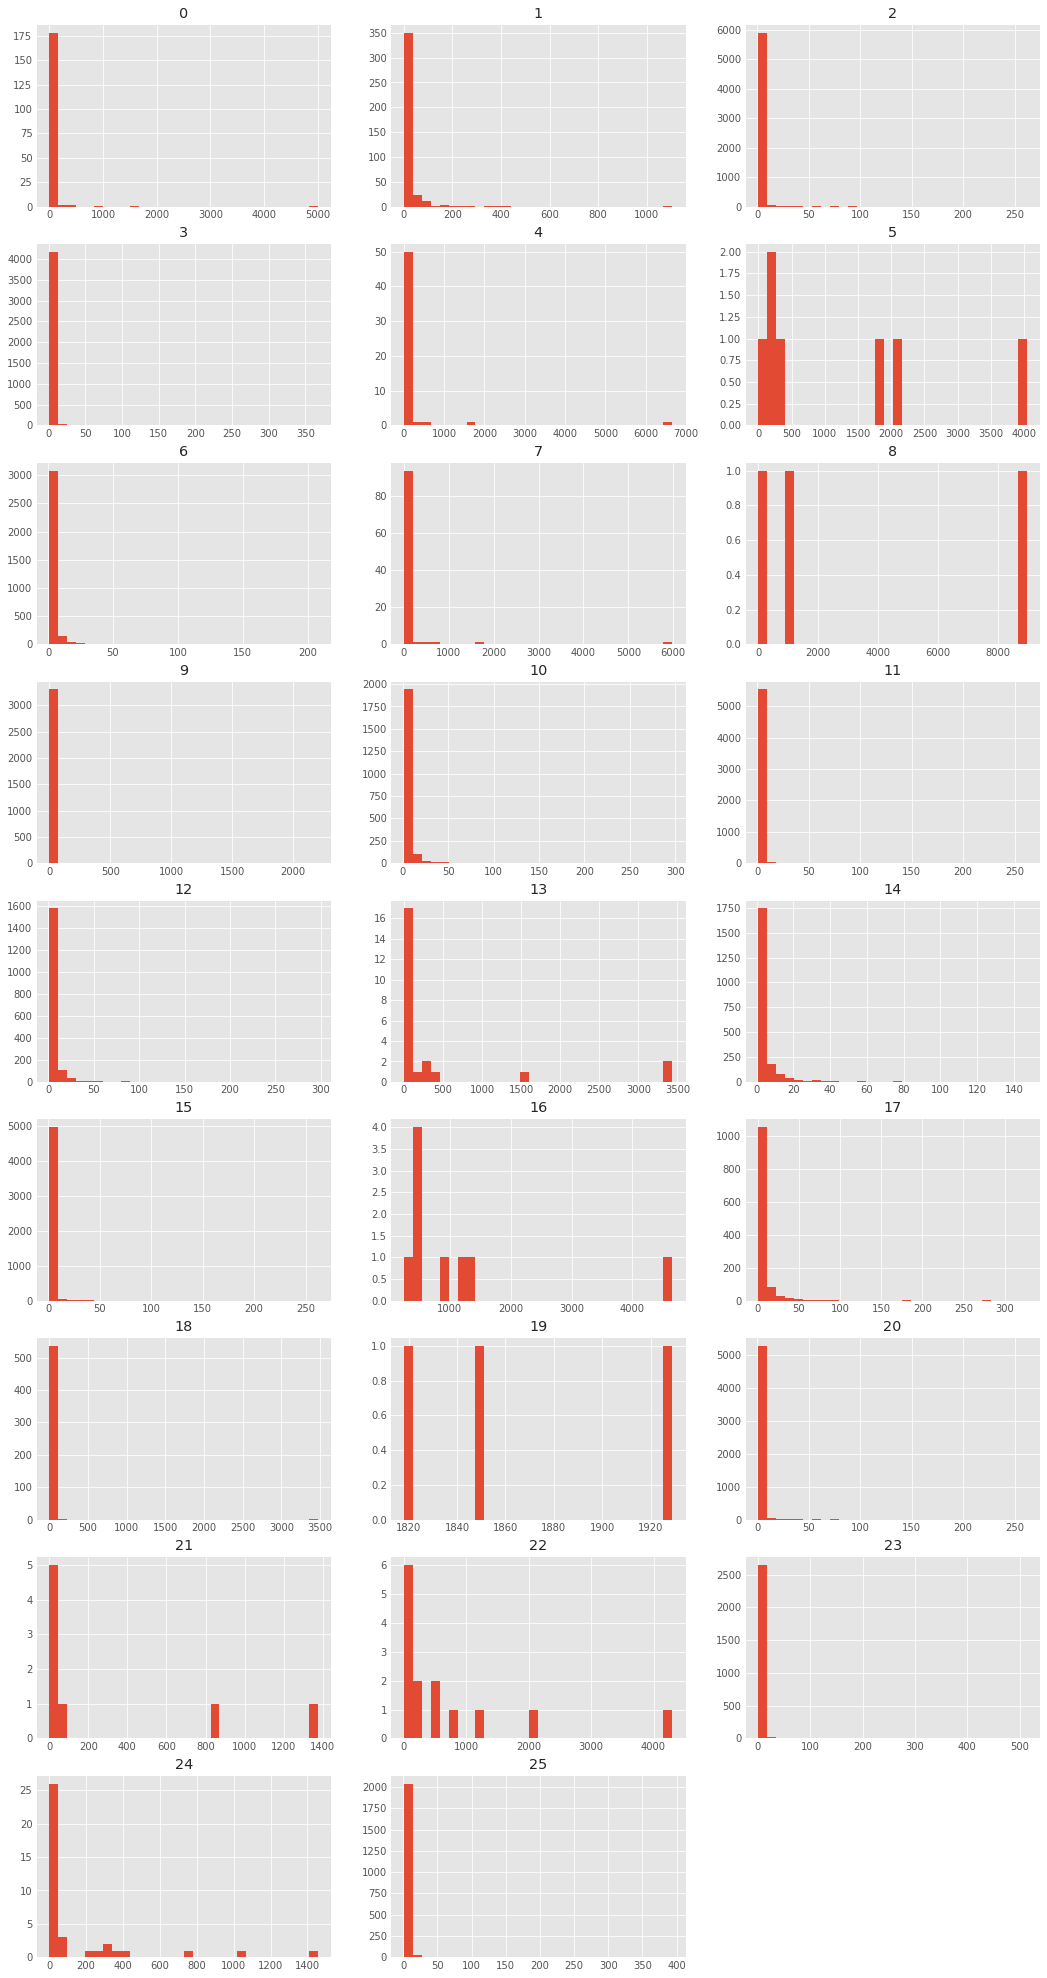

In [18]:
plt.figure(figsize=(18, 4 * len(category_df.columns)))
for i in category_df:
    counts = pd.value_counts(category_df[i])
    plt.subplot(len(category_df.columns), 3, i + 1)
    plt.hist(counts.values, bins=30)
    plt.title(i)

## Analyze Labels

About 3/4 of the labels are 0s.

In [19]:
np.mean(labels)

0.262

## Get Top-N Categories for Each Column

We need to figure out which categories are "non-rare". We'll count up all the categories, filter out any that occur fewer than 10 times, and get the most 50 frequent categories. Later during training, all the other categories will be replaced with the value `"RARE"`. We'll save the categories we select to a CSV file which can be reloaded later.

In [7]:
n = 50

def emit_categories(pair):
    """
    takes each row, and emits one record per categorical column. Emits in a key-value format with 2 tuples:
    (column_name, category_hash), (count_false, count_true, total_count)
    
    count_false is 1 if this row has a 0 label
    count_true is 1 if this row has a 1 label
    these two aren't necessary, but nice to know if the category shows up more frequently in a particular class
    total_count is always 1
    
    these numbers will get reduced and added later
    """
    row, label = pair
    # only loop over the categorical variables
    for i, val in enumerate(row[13:]):
        yield ("C" + str(i), val), (int(label == 0), int(label == 1), 1)

def shift_key(pair):
    """take a 2-tuple key, and make it 1 value instead"""
    (col_name, val), (neg_count, pos_count, total) = pair
    return col_name, (val, neg_count, pos_count, total)

def get_top_n(n):
    """for each group, get the top n by total_count"""
    def mapper(val_seq):
        val_seq = sorted(val_seq, key=lambda x: x[-1], reverse=True)
        return val_seq[:n]
    return mapper
        
category_counts = dataRDD.flatMap(emit_categories) \
    .reduceByKey(lambda tup_a, tup_b: (tup_a[0] + tup_b[0], tup_a[1] + tup_b[1], tup_a[2] + tup_b[2])) \
    .filter(lambda pair: pair[1][-1] >= 10) \
    .map(shift_key) \
    .groupByKey() \
    .mapValues(get_top_n(n)).cache()

num_significant_categories = category_counts.mapValues(len)

In [8]:
category_count_data = defaultdict(dict)

with open("data/freq_category_counts.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["col_name", "category", "neg_count", "pos_count", "total", "category_id"])
    
    # stream the results in to the master
    for row in category_counts.toLocalIterator():
        col_name, category_info = row
        # loop through all the categories and assign an integer ID for each, and save that to the CSV as well
        category_id = 0
        for info in category_info:
            category_name, neg_count, pos_count, total = info
            category_count_data[col_name][category_name] = { "neg": neg_count, "pos": pos_count }
            writer.writerow([col_name, category_name, neg_count, pos_count, total, category_id])
            category_id += 1

Furthermore, we need to know how many categories remain after this filtering (some have fewer than 50). We need to save this too.

In [9]:
with open("data/num_significant_categories.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["field", "count"])
    for row in num_significant_categories.toLocalIterator():
        writer.writerow(row)

## Correlation with Target

Finally, we'll wee if the values are distributed differently within each class label. Ideally, we would see some values occur much more commonly in one particular class, as it means we should be able to use that feature for a prediction.

For the numeric columns, we'll make 2 box plots for each (partitioned by label). Upon initial visual inspection, there don't seem to be any huge systematic differences across classes.

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


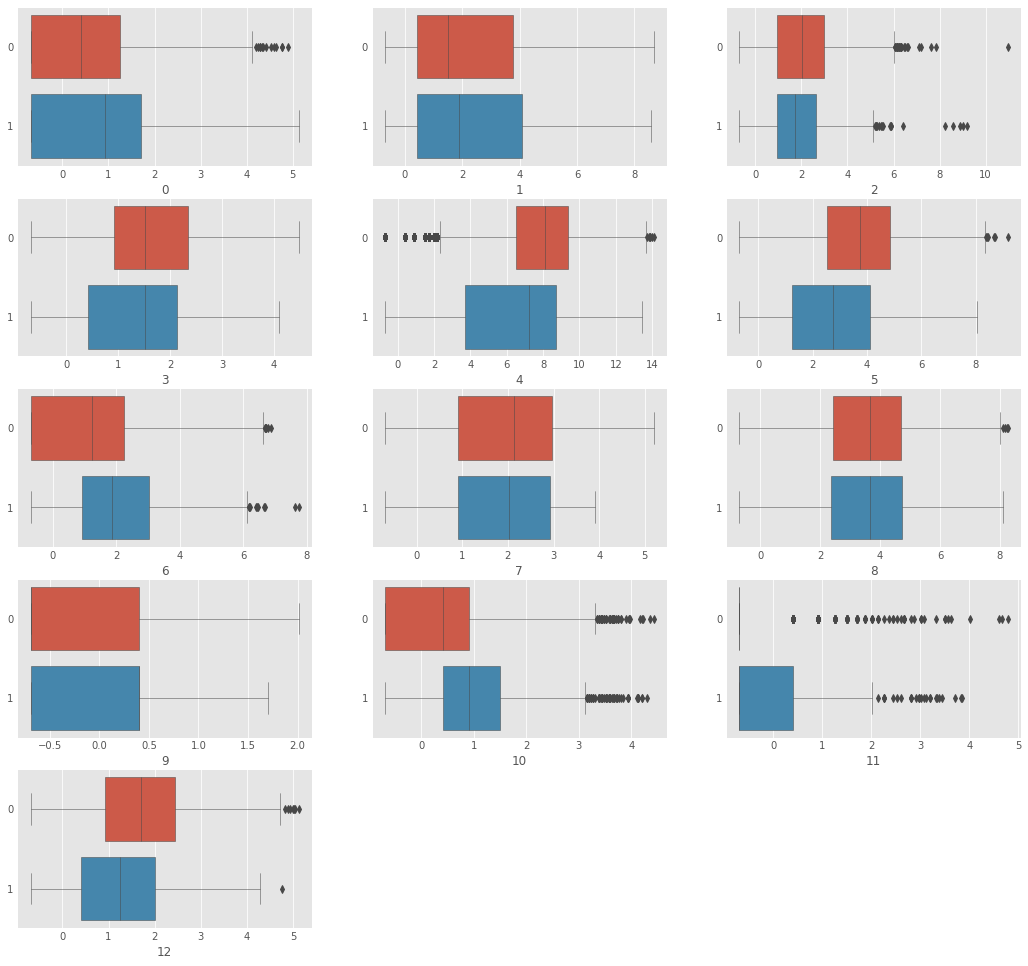

In [7]:
plt.figure(figsize=(18, 45))
for i in numeric_df:
    x = numeric_df[i]
    plt.subplot(len(numeric_df.columns), 3, i + 1)
    sb.boxplot(np.log(x + 0.5), labels, orient="h", linewidth=0.5)

plt.show()

Lastly, we'll see if the distributions of categories are different per class. For categorical data, this can be accomplished with a χ² test. This test assumes that the 2 groups are independent (null hypothesis). First we put the category distributions in a [contingency table](https://en.wikipedia.org/wiki/Contingency_table). Then, we compare each distribution with the "expected distribution", and add up the differences to get the chi-statistic. This number follows a χ² distribution. We can compute a p-value as potential evidence against the null hypothesis.

Most of the p-values are 0 or very close to 0. This means there are differences in the distributions of categories per class. This is good news, as it suggests we might use these to make a prediction. 

**NOTE:** Actually, I'm a little skeptical of this result. In my opinion, the χ² test rejects the null hypothesis too easily when there are some very small counts. Since there are a lot of rare categories, many of these columns have this *long tail* of rare counts. This may reject the null hypothesis, but would not imply prospects for predictive modeling.

In [47]:
col_names = []
chi2s = []
p_vals = []

for col_name, category_counts in category_count_data.items():
    neg_distribution = np.array([counts["neg"] for counts in category_counts.values()])
    pos_distribution = np.array([counts["pos"] for counts in category_counts.values()])
    chi2, p_val, _, expected = chi2_contingency([neg_distribution, pos_distribution])
    col_names.append(col_name)
    chi2s.append(chi2)
    p_vals.append(p_val)

chi2_test_df = pd.DataFrame({ "column": col_names, "χ²": chi2s, "p value": p_vals })
chi2_test_df

,column,χ²,p value
0,C0,57.634823,9.197836e-01
1,C22,1743.230967,0.000000e+00
2,C1,2519.274379,0.000000e+00
3,C17,2270.030955,0.000000e+00
4,C21,114.102383,1.291746e-21
5,C15,1891.177506,0.000000e+00
6,C8,1059.035454,1.079874e-230
7,C5,148.987757,6.623175e-29
8,C9,1150.053148,1.189559e-192
9,C23,2072.582861,0.000000e+00


# Summary of Insights

- Some columns have no nulls or very few, while others have many. Sometimes columns have nulls correlated with other columns. We won't be able to simply omit rows with missing data. This means we need to fill in values that are meaningfull, which may be challenging for some models.
- Most numerical values are very right-skewed. If this becomes a problem, we can try a log transform.
- There are some outlying negative values in the second integer column. Perhaps this is an error.
- There is little correlation bewteen the numerical columns. This is good, as it means there is little redundancy.
- The categorical columns consist mostly of a disarrangement of rare cetegories, i.e. most of the unique categories only show up in the data few times. This is not good. We can take all the rare categories and replace them with a special value (keeping only the top-k categories in each column), but that will remove some useful information. It also introduces another hyper-parameter, k.
- The classes are imbalanced. About 75% of the examples are negative. This will cause the models we train to favor high accuracy on the majority class unless we can weight the examples or re-sample.
- Not much evidence of any columns correlating strongly with the target, unfortunately.